In [ ]:
#| hide
!pip install -Uqq nixtla statsforecast mlforecast neuralforecast lightgbm

In [ ]:
#| hide 
from nixtla.utils import in_colab

/Users/yibeihu/opt/anaconda3/envs/report/lib/python3.9/site-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
#| hide 
IN_COLAB = in_colab()

In [ ]:
#| hide
if not IN_COLAB:
    from nixtla.utils import colab_badge
    from dotenv import load_dotenv

In [ ]:
#| echo: false
import warnings
warnings.filterwarnings("ignore")

# Why TimeGPT?

In this notebook, we compare the performance of TimeGPT against three forecasting models: the classical model (ARIMA), the machine learning model (LGBRegressor), and the deep learning model (N-HiTS), using a subset of data from the M5 Forecasting competition. We want to highlight three top-rated benefits our users love about TimeGPT:

🎯 **Accuracy**: TimeGPT consistently outperforms traditional models by capturing complex patterns with precision.

⚡ **Speed**: Generate forecasts faster without needing extensive training or tuning for each series.

🚀 **Ease of Use**: Minimal setup and no complex preprocessing make TimeGPT accessible and ready to use right out of the box!

Before diving into the notebook, please visit our [dashboard](https://dashboard.nixtla.io) to generate your TimeGPT `api_key` and give it a try yourself!

# Table of Contents

1. [Data Introduction](#data-introduction)
2. [Model Fitting](#model-fitting-timegpt-arima-lgbregressor-n-hits)
    1. [Fitting Time GPT](#timegpt)
    2. [Fitting ARIMA](#classical-models-arima)
    3. [Fitting Light GBM](#machine-learning-models-lgbmregressor)
    4. [Fitting NHITS](#n-hits)
3. [Results and Evaluation](#performance-comparison-and-results)
4. [Conclusion](#conclusion)

In [ ]:
#| echo: false
if not IN_COLAB:
    load_dotenv()
    colab_badge('docs/getting-started/7_why_timegpt')

[![](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Nixtla/nixtla/blob/main/nbs/docs/getting-started/7_why_timegpt.ipynb)

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from nixtla import NixtlaClient
from utilsforecast.plotting import plot_series
from utilsforecast.losses import mae, rmse, smape
from utilsforecast.evaluation import evaluate

In [ ]:
nixtla_client = NixtlaClient(
    # defaults to os.environ.get("NIXTLA_API_KEY")
    api_key = 'YOUR_API_KEY'
)

## 1. Data introduction

In this notebook, we’re working with an aggregated dataset from the M5 Forecasting - Accuracy competition. This dataset includes **7 daily time series**, each with **1,941 data points**. The last **28 data points** of each series are set aside as the test set, allowing us to evaluate model performance on unseen data.

In [ ]:
df = pd.read_csv('https://datasets-nixtla.s3.amazonaws.com/demand_example.csv')
df['ds'] = pd.to_datetime(df['ds'])

In [ ]:
df.groupby('unique_id').agg({"ds":["min","max","count"],\
                             "y":["min","mean","median","max"]})

ds                      y                                
                   min        max count   min          mean   median      max
unique_id                                                                    
FOODS_1     2011-01-29 2016-05-22  1941   0.0   2674.085523   2665.0   5493.0
FOODS_2     2011-01-29 2016-05-22  1941   0.0   4015.984029   3894.0   9069.0
FOODS_3     2011-01-29 2016-05-22  1941  10.0  16969.089129  16548.0  28663.0
HOBBIES_1   2011-01-29 2016-05-22  1941   0.0   2936.122617   2908.0   5009.0
HOBBIES_2   2011-01-29 2016-05-22  1941   0.0    279.053065    248.0    871.0
HOUSEHOLD_1 2011-01-29 2016-05-22  1941   0.0   6039.594539   5984.0  11106.0
HOUSEHOLD_2 2011-01-29 2016-05-22  1941   0.0   1566.840289   1520.0   2926.0

In [ ]:
df_train = df.query('ds <= "2016-04-24"')
df_test = df.query('ds > "2016-04-24"')

print(df_train.shape, df_test.shape)

(13391, 3) (196, 3)


## 2. Model Fitting (TimeGPT, ARIMA, LGBRegressor, N-HiTS)

### 2.1 TimeGPT
TimeGPT offers a powerful, streamlined solution for time series forecasting, delivering state-of-the-art results with minimal effort. With TimeGPT, there's no need for data preprocessing or feature engineering -- simply initiate the Nixtla client and call `nixtla_client.forecast` to produce accurate, high-performance forecasts tailored to your unique time series.


In [ ]:
# Forecast with TimeGPT
fcst_timegpt = nixtla_client.forecast(df = df_train,
                       target_col = 'y', 
                       h=28,                              # Forecast horizon, predicts the next 28 time steps
                       model='timegpt-1-long-horizon',    # Use the model for long-horizon forecasting
                       finetune_steps=10,                 # Number of finetuning steps
                       level = [90])                      # Generate a 90% confidence interval

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Inferred freq: D
INFO:nixtla.nixtla_client:Querying model metadata...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


In [ ]:
# Evaluate performance and plot forecast
fcst_timegpt['ds'] = pd.to_datetime(fcst_timegpt['ds'])
test_df = pd.merge(df[-28:], fcst_timegpt, 'left', ['unique_id', 'ds'])
evaluation_timegpt = evaluate(test_df, metrics=[rmse, smape], models=["TimeGPT"])
evaluation_timegpt.groupby(['metric'])['TimeGPT'].mean()

metric
rmse     370.94408
smape      0.03975
Name: TimeGPT, dtype: float64

### 2.2 Classical Models (ARIMA):
Secondly, we applied ARIMA, a classical statistical model, to the same forecasting task. Here, ARIMA struggled to capture the data's intricate, non-linear patterns, resulting in comparatively lower accuracy.

> 📘 Why Use TimeGPT over Classical Models?
>
> * **Complex Patterns**: TimeGPT captures non-linear trends classical models miss.
>
> * **Minimal Preprocessing**: TimeGPT requires little to no data preparation.
>
> * **Scalability**: TimeGPT can efficiently scales across multiple series without retraining.

In [ ]:
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA

In [ ]:
#Initiate ARIMA model
sf = StatsForecast(
    models=[AutoARIMA()],
    freq='D'
)
# Fit and forecast
fcst_arima = sf.forecast(h=28, df=df_train) 

In [ ]:
fcst_arima.reset_index(inplace=True)
test_df = pd.merge(df[-28:], fcst_arima, 'left', ['unique_id', 'ds'])
evaluation_arima = evaluate(test_df, metrics=[rmse, smape], models=["AutoARIMA"])
evaluation_arima.groupby(['metric'])['AutoARIMA'].mean()

metric
rmse     1167.535431
smape       0.082995
Name: AutoARIMA, dtype: float64

### 2.3 Machine Learning Models (LGBMRegressor)

Thirdly, we used machine learning model (LGBRegressor) for the same task. While LGBRegressor can capture seasonality and patterns, it requires detailed feature engineering, careful tuning, and domain knowledge to optimize performance.

> 📘 Why Use TimeGPT over Machine Learning Models?
>
> * **Automatic Pattern Recognition**: Captures complex patterns from raw data, bypassing the need for feature engineering.
>
> * **Minimal Tuning**: Works well without extensive tuning.
>
> * **Scalability**: Forecasts across multiple series without retraining.

In [ ]:
from mlforecast import MLForecast
from mlforecast.target_transforms import Differences
from mlforecast.utils import PredictionIntervals
from window_ops.expanding import expanding_mean
from lightgbm import LGBMRegressor

In [ ]:
#| echo: true
#| eval: false
# Model initiation and feature engineering
mlf = MLForecast(
    models=[LGBMRegressor()],  # Use LightGBM as an example for ML models
    freq='D',                  # Frequency of the data - 'D' for daily frequency
    lags=list(range(1, 7)),    # Specific lags to use as regressors: 1 to 6 days
    lag_transforms = {
        1:  [expanding_mean]   # Apply expanding mean transformation to the lag of 1 day
    },
    date_features=['year', 'month', 'day', 'dayofweek', 'quarter', 'week'],  # Date features to use as regressors
)

mlf.fit(df_train)
fcst_lgbm = mlf.predict(28, level=[90])

In [ ]:
test_df = pd.merge(df[-28:], fcst_lgbm, 'left', ['unique_id', 'ds'])
evaluation_lgbm = evaluate(test_df, metrics=[rmse, smape], models=["LGBMRegressor"])
evaluation_lgbm.groupby(['metric'])['LGBMRegressor'].mean()

metric
rmse     816.728545
smape      0.080619
Name: LGBMRegressor, dtype: float64

### 2.4 N-HiTS

Lastly, we used N-HiTS, a state-of-the-art deep learning model designed for time series forecasting. The model produced accurate results, demonstrating its ability to capture complex, non-linear patterns within the data. However, setting up and tuning N-HiTS required significantly more time and computational resources compared to TimeGPT.

> 📘 Why Use TimeGPT Over Deep Learning Models?
>
> * **Faster Setup**: Quick setup and forecasting, unlike the lengthy configuration and training times of neural networks.
>
> * **Less Tuning**: Performs well with minimal tuning and preprocessing, while neural networks often need extensive adjustments.
>
> * **Ease of Use**: Simple deployment with high accuracy, making it accessible without deep technical expertise.

In [ ]:
from neuralforecast.core import NeuralForecast
from neuralforecast.models import NHITS

In [ ]:
#| echo: true
#| eval: false
models = [NHITS(h=28,
                input_size=365,
                scaler_type='robust',
                batch_size=16,
                valid_batch_size=8)]

nf = NeuralForecast(models=models, freq='D')
nf.fit(df=df_train)
fcst_nhits = nf.predict()

Since this machine doesn’t have GPU, the result is trained using Google Colabs.

In [ ]:
fcst_nhits = pd.read_csv('https://datasets-nixtla.s3.amazonaws.com/nhits_rst.csv')
fcst_nhits['ds'] = pd.to_datetime(fcst_nhits['ds'])

In [ ]:
test_df = pd.merge(df[-28:],fcst_nhits, 'left', ['unique_id', 'ds'])
evaluation_nhits = evaluate(test_df, metrics=[rmse, smape], models=["NHITS"])
evaluation_nhits.groupby(['metric'])['NHITS'].mean()

metric
rmse     748.603243
smape      0.060604
Name: NHITS, dtype: float64

## 3. Performance Comparison and Results:
The performance of each model is evaluated using RMSE (Root Mean Squared Error) and SMAPE (Symmetric Mean Absolute Percentage Error). While RMSE emphasizes the models’ ability to control significant errors, SMAPE provides a relative performance perspective by normalizing errors as percentages. Below, we present a snapshot of performance across all groups. The results demonstrate that TimeGPT outperforms other models on both metrics.

🌟 For a deeper dive into benchmarking, check out our benchmark repository. The summarized results are displayed below:

#### Overall Performance Metrics

| **Model**        | **RMSE** | **SMAPE** |
|------------------|----------|-----------|
| ARIMA            | 1167.5   | 8.30%     |
| LGBRegressor     | 816.7    | 8.06%     |
| N-HiTS           | 748.6    | 6.06%     |
| **TimeGPT**      | **370.9**| **3.98%** |


#### Breakdown for Each Time-series
Followed below are the metrics for each individual time series groups. Our analysis shows that TimeGPT consistently outperforms the other models, achieving the best results for all but one group.

In [ ]:
#| echo: false
evaluation_df = evaluation_arima.merge(evaluation_lgbm, on = ['unique_id','metric'], how = 'left')\
                 .merge(evaluation_nhits, on = ['unique_id','metric'], how = 'left')\
                 .merge(evaluation_timegpt, on = ['unique_id','metric'], how = 'left')#| echo: false

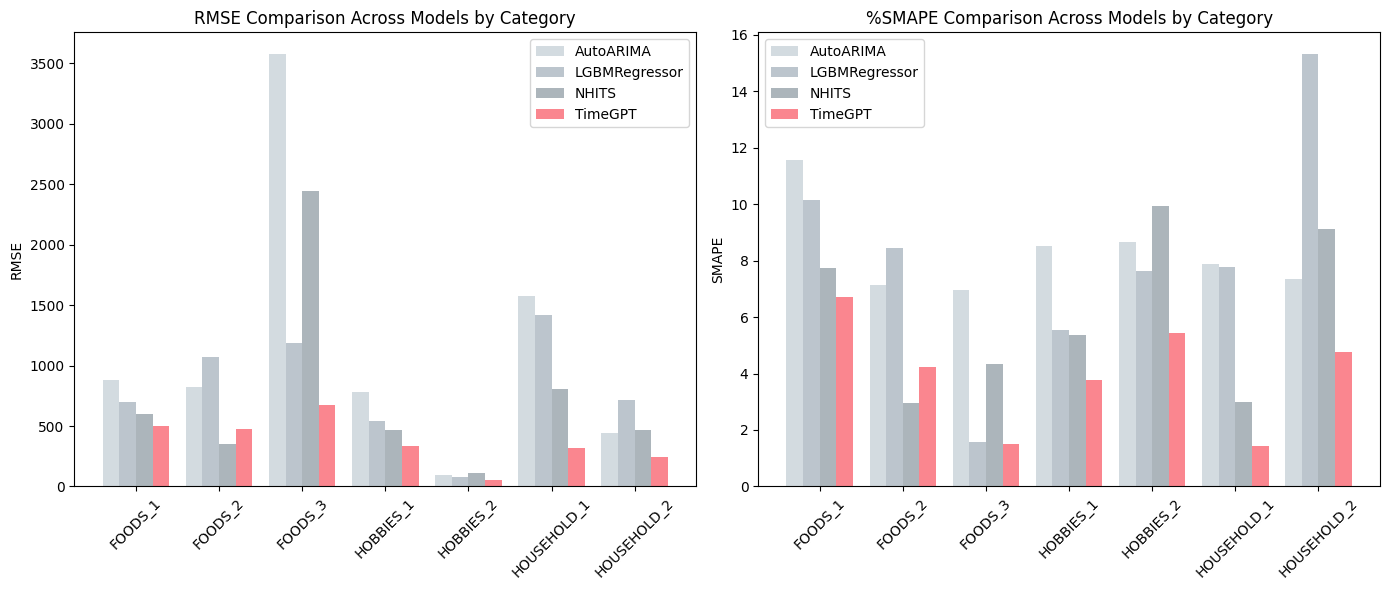

In [ ]:
#| echo: false
colors = [
    ("#A9B9C3", 0.5),  # Grey-bluish color 1
    ("#7A8D9D", 0.5),  # Grey-bluish color 2
    ("#5B6D79", 0.5),  # Grey-bluish color 3
    ('#F95D6A', 0.75)   # Green color for the last
]


# Filter evaluation data by metric and set unique_id as index
rmse_df = evaluation_df[evaluation_df['metric'] == 'rmse'].set_index('unique_id')
smape_df = evaluation_df[evaluation_df['metric'] == 'smape'].set_index('unique_id')

# Plot function with custom colors and opacity
def plot_metric(ax, df, title, ylabel):
    x = np.arange(len(df))
    bar_width = 0.2
    for i, (col, (color, alpha)) in enumerate(zip(df.columns[1:], colors)):
        ax.bar(x + i * bar_width, df[col], width=bar_width, label=col, color=color, alpha=alpha)
    ax.set(title=title, ylabel=ylabel, xticks=x + bar_width * (len(df.columns[1:]) - 1) / 2, xticklabels=df.index)
    ax.tick_params(axis='x', rotation=45)
    ax.legend()

# Generate side-by-side plots for RMSE and SMAPE
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
plot_metric(axes[0], rmse_df, "RMSE Comparison Across Models by Category", "RMSE")
plot_metric(axes[1], smape_df*100, "%SMAPE Comparison Across Models by Category", "SMAPE")

plt.tight_layout()
plt.show()

#### Benchmark Results
For a more comprehensive dive into model accuracy and performance, explore our [Time Series Model Arena](https://github.com/Nixtla/nixtla/tree/main/experiments/foundation-time-series-arena)! TimeGPT continues to lead the pack with exceptional performance across benchmarks! 🌟

![image](https://github.com/Nixtla/nixtla/assets/10517170/1c042591-0585-4a5b-a548-2017a28f2d4f)

## 4. Conclusion
At the end of this notebook, we’ve put together a handy table to show you exactly where TimeGPT shines brightest compared to other forecasting models. ☀️ Think of it as your quick guide to choosing the best model for your unique project needs. We’re confident that TimeGPT will be a valuable tool in your forecasting journey. Don’t forget to visit our [dashboard](https://dashboard.nixtla.io) to generate your TimeGPT `api_key` and get started today! Happy forecasting, and enjoy the insights ahead! 

<table>
  <thead>
    <tr>
      <th>Scenario</th>
      <th>TimeGPT</th>
      <th>Classical Models (e.g., ARIMA)</th>
      <th>Machine Learning Models (e.g., XGB, LGBM)</th>
      <th>Deep Learning Models (e.g., N-HITS)</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>Seasonal Patterns</td>
      <td>✅ Performs well with minimal setup</td>
      <td>✅ Handles seasonality with adjustments (e.g., SARIMA)</td>
      <td>✅ Performs well with feature engineering</td>
      <td>✅ Captures seasonal patterns effectively</td>
    </tr>
    <tr>
      <td>Non-Linear Patterns</td>
      <td>✅ Excels, especially with complex non-linear patterns</td>
      <td>❌ Limited performance</td>
      <td>❌ Struggles without extensive feature engineering</td>
      <td>✅ Performs well with non-linear relationships</td>
    </tr>
    <tr>
      <td>Large Dataset</td>
      <td>✅ Highly scalable across many series</td>
      <td>❌ Slow and resource-intensive</td>
      <td>✅ Scalable with optimized implementations</td>
      <td>❌ Requires significant resources for large datasets</td>
    </tr>
    <tr>
      <td>Small Dataset</td>
      <td>✅ Performs well; requires only one data point to start</td>
      <td>✅ Performs well; may struggle with very sparse data</td>
      <td>✅ Performs adequately if enough features are extracted</td>
      <td>❌ May need a minimum data size to learn effectively</td>
    </tr>
    <tr>
      <td>Preprocessing Required</td>
      <td>✅ Minimal preprocessing needed</td>
      <td>❌ Requires scaling, log-transform, etc., to meet model assumptions.</td>
      <td>❌ Requires extensive feature engineering for complex patterns</td>
      <td>❌ Needs data normalization and preprocessing</td>
    </tr>
    <tr>
      <td>Accuracy Requirement</td>
      <td>✅ Achieves high accuracy with minimal tuning</td>
      <td>❌ May struggle with complex accuracy requirements</td>
      <td>✅ Can achieve good accuracy with tuning</td>
      <td>✅ High accuracy possible but with significant resource use</td>
    </tr>
    <tr>
      <td>Scalability</td>
      <td>✅ Highly scalable with minimal task-specific configuration</td>
      <td>❌ Not easily scalable</td>
      <td>✅ Moderate scalability, with feature engineering and tuning per task</td>
      <td>❌ Limited scalability due to resource demands</td>
    </tr>
    <tr>
      <td>Computational Resources</td>
      <td>✅ Highly efficient, operates seamlessly on CPU, no GPU needed</td>
      <td>✅ Light to moderate, scales poorly with large datasets</td>
      <td>❌ Moderate, depends on feature complexity</td>
      <td>❌ High resource consumption, often requires GPU</td>
    </tr>
    <tr>
      <td>Memory Requirement</td>
      <td>✅ Efficient memory usage for large datasets</td>
      <td>✅ Moderate memory requirements</td>
      <td>❌ High memory usage for larger datasets or many series cases</td>
      <td>❌ High memory consumption for larger datasets and multiple series</td>
    </tr>
    <tr>
      <td>Technical Requirements & Domain Knowledge</td>
      <td>✅ Low; minimal technical setup and no domain expertise needed</td>
      <td>✅ Low to moderate; needs understanding of stationarity</td>
      <td>❌ Moderate to high; requires feature engineering and tuning</td>
      <td>❌ High; complex architecture and tuning</td>
    </tr>
  </tbody>
</table>
